# GAN met Fashion MNIST

In deze notebook gaan we opnieuw beelden genereren op basis van de Fashin MNIST dataset, net zoals in de vorige notebook over variational autoencoders (VAE). 
Hierbij moeten we een generator en discriminator opstellen.

## Importeren van packages en dataset

Eerst importeren we alle benodigde Python-bibliotheken voor het bouwen, trainen en visualiseren van onze VAE.
We gebruiken Pytorch voor het bouwen van het neurale netwerk, matplotlib voor visualisaties en NumPy voor numerieke berekeningen.
Daarna laden we de Fashion MNIST dataset, normaliseren de pixelwaarden naar de range [-1,1] 
en splitsen de dataset in een trainings- en testset. We gebruiken DataLoader om mini-batches te maken voor training.

In [56]:
# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen 0 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteert beeld naar tensor
    transforms.Normalize((0), (1.0))
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader voor batches van de trainingsdata
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

print("Data geladen en DataLoader klaar.")

Data geladen en DataLoader klaar.


## Generator

 Deze cel definieert de generator die een random vector van ruis (latent vector) gebruikt om een afbeelding van 28x28 pixels te genereren. Het netwerk bestaat uit vier volledig verbonden lagen met ReLU-activatie, gevolgd door een Tanh activatie om de output te normaliseren.

In [57]:
# Generator model
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Gebruik Tanh om de output te normaliseren naar het bereik [-1, 1] (zelfde als input)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialiseer de generator
latent_dim = 100  # Dimensie van de input ruis vector
generator = Generator(input_dim=latent_dim, output_dim=28*28).to(device)
print(generator)


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


## Discriminator

Deze cel definieert de discriminator, die een afbeelding van 28x28 pixels als invoer ontvangt en een enkele waarde teruggeeft die aangeeft of de afbeelding echt is (uit de dataset) of vals (gegenereerd door de generator). Het netwerk bestaat uit vier volledig verbonden lagen met LeakyReLU-activatie en dropout om overfitting te voorkomen.

In [58]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Gebruik Sigmoid om de output te normaliseren naar het bereik [0, 1]
        )
        
    def forward(self, x):
        return self.model(x)

# Initialiseer de discriminator
discriminator = Discriminator(input_dim=28*28).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## Loss functions

In deze cel worden de verliesfunctie en de optimalizers voor de generator en discriminator gedefinieerd. We gebruiken binaire cross-entropy (BCELoss) als verliesfunctie en de Adam-optimizer voor zowel de generator als de discriminator.

In [59]:
# Verliesfunctie
criterion = nn.BCELoss()

# Optimalizers voor generator en discriminator
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)


## Trainen van het GAN model

De discriminator wordt getraind met zowel echte als gegenereerde afbeeldingen om te leren onderscheid te maken tussen de twee, terwijl de generator wordt getraind om betere afbeeldingen te genereren die de discriminator niet kan onderscheiden van echte. Voor elke epoch printen we het verlies van zowel de generator als de discriminator.

In [60]:
# Functie om echte en neppe labels te maken
def real_data_target(size):
    return torch.ones(size, 1).to(device)

def fake_data_target(size):
    return torch.zeros(size, 1).to(device)
    

# Set the path to save/load the model
gen_path = "02_ganmodel_gen.pth"
discr_path = "02_ganmodel_dis.pth"

# Check if the model file exists
if os.path.exists(gen_path):
    print("Loading existing model...")
    generator.load_state_dict(torch.load(gen_path))
    discriminator.load_state_dict(torch.load(discr_path))
    generator.eval()  # Set model to evaluation mode if only inference is required
    discriminator.eval() 
else:
    # Trainen van het GAN model
    num_epochs = 10
    for epoch in range(num_epochs):
        for n, (real_images, _) in enumerate(train_loader):
            # Trainen van de Discriminator met echte afbeeldingen
            real_images = real_images.view(real_images.size(0), -1).to(device)  # Flatten de afbeeldingen
            real_labels = real_data_target(real_images.size(0))
            
            optimizer_D.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()
            
            # Trainen van de Discriminator met gegenereerde (neppe) afbeeldingen
            noise = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_images = generator(noise)
            fake_labels = fake_data_target(real_images.size(0))
             
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_D.step()
    
            # Totaal verlies voor de discriminator
            d_loss = d_loss_real + d_loss_fake
            
            # Trainen van de Generator
            optimizer_G.zero_grad()
            outputs = discriminator(fake_images)      # Opnieuw voorspellen na trainen van discriminator!
            g_loss = criterion(outputs, real_labels)  # Probeer de discriminator voor de gek te houden
            g_loss.backward()
            optimizer_G.step()
    
        # Print verlies na elke epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")
        
    # Save the model after training
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), discr_path)
    print(f"Model saved to {gen_path}")
    
print("Training voltooid.")


Epoch [1/10], d_loss: 1.2578, g_loss: 1.1237
Epoch [2/10], d_loss: 0.6055, g_loss: 1.3142
Epoch [3/10], d_loss: 0.8123, g_loss: 1.9726
Epoch [4/10], d_loss: 0.9808, g_loss: 1.2835
Epoch [5/10], d_loss: 0.9108, g_loss: 1.3654
Epoch [6/10], d_loss: 0.9432, g_loss: 1.4311
Epoch [7/10], d_loss: 1.1362, g_loss: 1.2871
Epoch [8/10], d_loss: 0.9813, g_loss: 1.4506
Epoch [9/10], d_loss: 0.8841, g_loss: 1.4848
Epoch [10/10], d_loss: 1.2356, g_loss: 1.1574
Model saved to 02_ganmodel_gen.pth
Training voltooid.


## Visualiseren van de resultaten

Deze cel definieert een functie om enkele gegenereerde afbeeldingen van de getrainde generator te visualiseren. Het genereert willekeurige ruis en laat de generator nieuwe afbeeldingen maken, die vervolgens worden weergegeven met behulp van Matplotlib.

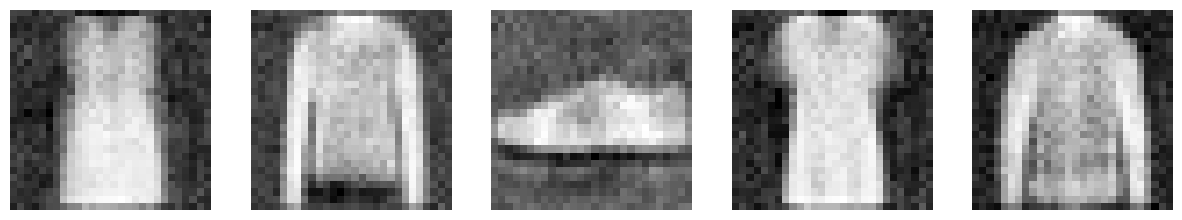

In [63]:
# Functie om gegenereerde afbeeldingen te visualiseren
def show_generated_images(generator, latent_dim, num_images=5):
    generator.eval()
    noise = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_images = generator(noise).cpu().view(num_images, 28, 28)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Visualiseer enkele gegenereerde afbeeldingen na training
show_generated_images(generator, latent_dim)